<a href="https://colab.research.google.com/github/melhscientist/ClasificacionCNN_CancerEstomago/blob/main/MIADS_DL_Proyecto_MElizabeth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1\. Objetivo

A continuación, te presento el código completo para un notebook de Google Colab que sigue la metodología propuesta. Este notebook está diseñado para ser ejecutado paso a paso, con comentarios claros y secciones bien definidas para cada etapa de tu proyecto. El código utiliza **PyTorch** por su flexibilidad y amplia comunidad en el ámbito de la investigación.


-----

## 2\. Preparación del Entorno y de los Datos

En esta sección, configuraremos el entorno de Colab, instalaremos las bibliotecas necesarias y cargaremos nuestro dataset.

Para este clasificador se utilizaron solamente las imágenes de tejido sano y las imágenes de tejido con displasia/cáncer. De manera que el conjuntode datos está formado por 1,469 imágenes de tejido sano (clase 0) y 3,594 imágenes de displasia/cáncer (clase 1).

Las imágenes originales fueron escaladas de 519x521 pixeles a 260x260 para reducir el tiempo y la memoria requeridos para el procesamiento. El conjunto de imágenes utilizadas están disponibles en el archivo comprimido imagenes_260x260.zip

In [ ]:
# @title 2.1. Instalación de bibliotecas y configuración del entorno
!pip install --quiet torchinfo timm
!pip install --quiet ipywidgets

import os
import zipfile
import pandas as pd
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from torchinfo import summary
from tqdm.notebook import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.2 MB/s eta 0:00:00


In [ ]:
# Aseguramos el uso de la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

Usando el dispositivo: cuda


In [ ]:
# @title 2.2. Carga y descompresión de los datos
# Una vez subidos, descomprime las imágenes
!unzip -q imagenes_260x260.zip

Primeras 5 filas del dataset:
   Unnamed: 0 image_filename  class_number
0           0     im_4_0.png             0
1           1    im_21_0.png             0
2           2     im_9_0.png             0
3           3     im_8_0.png             0
4           4    im_15_0.png             0

Conteo de imágenes por clase:
class_number
1    3594
0    1469
Name: count, dtype: int64


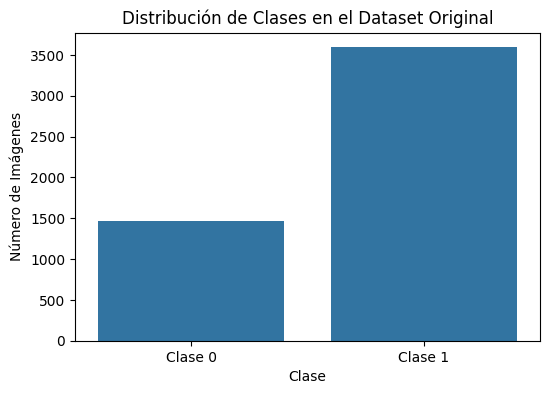

In [ ]:
# @title 2.3. Análisis del dataset y balanceo de clases
# Cargar el archivo CSV
df = pd.read_csv('ClasesImagenes.csv')

# Mostrar las primeras filas del DataFrame
print("Primeras 5 filas del dataset:")
print(df.head())

# Contar el número de imágenes por clase
class_counts = df['class_number'].value_counts()
print("\nConteo de imágenes por clase:")
print(class_counts)

# Graficar la distribución de clases
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribución de Clases en el Dataset Original')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(ticks=[0, 1], labels=['Clase 0', 'Clase 1'])
plt.show()

**Análisis y Solución para el Desbalanceo:**

Observamos que el dataset está **altamente desbalanceado**, con la clase 1 teniendo muchas más muestras que la clase 0. Un modelo entrenado en este dataset podría sobreajustarse a la clase mayoritaria y tener un mal desempeño en la clase minoritaria.

Para abordar esto, aplicaremos una estrategia de **balanceo de clases** durante el entrenamiento. En este caso, podríamos llegar a usar el **sobremuestreo (oversampling)** de la clase minoritaria. Esto implica duplicar o triplicar aleatoriamente las imágenes de la clase con menos muestras para igualar el número de imágenes en ambas clases. Esto se implementará directamente en la función de carga de datos para los sets de entrenamiento.


## 3\. Preprocesamiento de Datos y Aumento de Datos

Aquí definiremos las transformaciones necesarias para preparar las imágenes para el entrenamiento.


In [ ]:
# @title 3.1. Definición de las transformaciones
# Se definen las transformaciones para el conjunto de entrenamiento
# Estas transformaciones incluyen aumento de datos para mejorar la generalización del modelo.
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),      # Redimensionar la imagen a un tamaño estándar (requerido por los modelos pre-entrenados)
    transforms.RandomHorizontalFlip(),   # Voltear la imagen horizontalmente de forma aleatoria para aumentar la variabilidad
    transforms.RandomRotation(15),       # Rotar la imagen aleatoriamente
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Ajustar brillo y contraste aleatoriamente
    transforms.ToTensor(),               # Convertir la imagen a un tensor de PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizar con los valores de ImageNet
])

# Se definen las transformaciones para los conjuntos de validación y prueba
# Estas transformaciones no incluyen aumento de datos, solo el redimensionamiento y la normalización
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## 4\. Implementación y Entrenamiento de Modelos

Aquí se presenta la implementación del entrenamiento para cada modelo seleccionado. Utilizaremos el **mismo protocolo experimental** (optimizador, función de pérdida y número de épocas) para una comparación justa.
* función de pérdida: CrossEntropyLoss
* optimizador: Adam (Aprende más rápido y suele converger mejor...segun papers. Pribar SGD)
* lr: 0.001
* epocas: 5



### 4.2. Función auxiliar para el entrenamiento y la evaluación

In [ ]:

# @title 4.2.1. Definición del bucle de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validación
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_epoch_loss = running_val_loss / len(val_loader.dataset)
        val_epoch_acc = correct_val / total_val
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nEntrenamiento completo en {elapsed_time:.2f} segundos.")
    return train_losses, train_accuracies, val_losses, val_accuracies, elapsed_time


In [ ]:
### 4.3. Implementación y entrenamiento de ResNet-50

#Estoy cargando una ResNet-50 que ya viene entrenada en ImageNet, lista para usar y adaptar a mi propio problema

# @title 4.3.1. Carga del modelo y definición de los datos
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split

# Dividir el conjuntos de entrenamiento, validación y prueba
# 70% train, 15% validación,15% prueba
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class_number'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class_number'], random_state=42)

# Definir el dataset personalizado
class ImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 1]
        # Correct the image path to point directly to the root directory
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 2])
        if self.transform:
            image = self.transform(image)
        return image, label

# Instanciar los datasets
# Set the root_dir to the content directory where the images are located
train_dataset = ImageDataset(train_df, '/content/', train_transforms)
val_dataset = ImageDataset(val_df, '/content/', val_transforms)
test_dataset = ImageDataset(test_df, '/content/', val_transforms)

# Balanceo de clases para el set de entrenamiento
class_weights = 1. / class_counts.values
samples_weight = class_weights[train_dataset.dataframe['class_number']]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True) #pesos por clase en la función de pérdida para reducir el sesgo hacia clases frecuentes

# Instanciar los DataLoaders
batch_size = 8 # Con 32 me quedé sin memoria
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # shuffle=False: aquí no se mezclan los datos,porque no entrenamos,solo medimos desempeño
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #shuffle=False: aquí no se mezclan los datos,porque no entrenamos,solo medimos desempeño

# Cargar el modelo ResNet-50 pre-entrenado
#ResNet-50 es una red convolucional con 50 capas profundas y conexiones residuales
# weights='IMAGENET1K_V1' -> carga los pesos pre-entrenados en el dataset ImageNet-1K (1,000 clases de objetos: gatos, perros, autos, etc.).
#“V1” indica la primera versión de esos pesos estándar.
model_resnet = models.resnet50(weights='IMAGENET1K_V1')

# Modificar la última capa para la clasificación binaria
num_ftrs_resnet = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs_resnet, 2)
model_resnet = model_resnet.to(device)

# Definir la función de pérdida y el optimizador
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

# Información del modelo
print("Información del modelo ResNet-50:")
summary(model_resnet, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], verbose=0)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


Información del modelo ResNet-50:


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [8, 3, 224, 224]          [8, 2]                    --                        True
├─Conv2d: 1-1                            [8, 3, 224, 224]          [8, 64, 112, 112]         9,408                     True
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         [8, 64, 112, 112]         128                       True
├─ReLU: 1-3                              [8, 64, 112, 112]         [8, 64, 112, 112]         --                        --
├─MaxPool2d: 1-4                         [8, 64, 112, 112]         [8, 64, 56, 56]           --                        --
├─Sequential: 1-5                        [8, 64, 56, 56]           [8, 256, 56, 56]          --                        True
│    └─Bottleneck: 2-1                   [8, 64, 56, 56]           [8, 256, 56, 56]          --                        True
│    │ 

In [ ]:
# @title 4.3.2. Entrenamiento de ResNet-50
print("Iniciando entrenamiento de ResNet-50...")
metrics_resnet = train_model(model_resnet, train_loader, val_loader, criterion_resnet, optimizer_resnet, num_epochs=5)
train_losses_resnet, train_acc_resnet, val_losses_resnet, val_acc_resnet, time_resnet = metrics_resnet


Iniciando entrenamiento de ResNet-50...


Epoch 1/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 1/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [1/5] - Train Loss: 0.3429, Train Acc: 0.8660, Val Loss: 0.5162, Val Acc: 0.8090


Epoch 2/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 2/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [2/5] - Train Loss: 0.2693, Train Acc: 0.8894, Val Loss: 0.3392, Val Acc: 0.8590


Epoch 3/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 3/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [3/5] - Train Loss: 0.2324, Train Acc: 0.8995, Val Loss: 0.3288, Val Acc: 0.8643


Epoch 4/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 4/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [4/5] - Train Loss: 0.2346, Train Acc: 0.9069, Val Loss: 0.2575, Val Acc: 0.8762


Epoch 5/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 5/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [5/5] - Train Loss: 0.2133, Train Acc: 0.9125, Val Loss: 0.2151, Val Acc: 0.8986

Entrenamiento completo en 313.15 segundos.


In [ ]:
### 4.4. Implementación y entrenamiento de Vision Transformer (ViT)
# 'vit_base_patch16_224'
#vit_base → el modelo “base” de Vision Transformer (ni muy pequeño ni muy grande).
#patch16 → la imagen se divide en parches de 16×16 píxeles antes de pasarlos al Transformer.
# 224 → el modelo espera imágenes de 224×224 píxeles (igual que ResNet).

# @title 4.4.1. Carga del modelo y definición de los datos
import timm

# Cargar el modelo Vision Transformer pre-entrenado
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True) #pretrained=True Descarga y carga pesos ya entrenados en ImageNet (dataset de 1,000 clases)

# Modificar la última capa para la clasificación binaria
num_ftrs_vit = model_vit.head.in_features
model_vit.head = nn.Linear(num_ftrs_vit, 2)
model_vit = model_vit.to(device)

# Definir la función de pérdida y el optimizador
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.Adam(model_vit.parameters(), lr=0.001)

# Información del modelo
print("Información del modelo ViT:")
summary(model_vit, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], verbose=0)


Información del modelo ViT:


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                        [8, 3, 224, 224]          [8, 2]                    152,064                   True
├─PatchEmbed: 1-1                        [8, 3, 224, 224]          [8, 196, 768]             --                        True
│    └─Conv2d: 2-1                       [8, 3, 224, 224]          [8, 768, 14, 14]          590,592                   True
│    └─Identity: 2-2                     [8, 196, 768]             [8, 196, 768]             --                        --
├─Dropout: 1-2                           [8, 197, 768]             [8, 197, 768]             --                        --
├─Identity: 1-3                          [8, 197, 768]             [8, 197, 768]             --                        --
├─Identity: 1-4                          [8, 197, 768]             [8, 197, 768]             --                        --
├─Sequentia

In [ ]:

# @title 4.4.2. Entrenamiento de ViT
print("Iniciando entrenamiento de Vision Transformer...")
metrics_vit = train_model(model_vit, train_loader, val_loader, criterion_vit, optimizer_vit, num_epochs=5)
train_losses_vit, train_acc_vit, val_losses_vit, val_acc_vit, time_vit = metrics_vit


Iniciando entrenamiento de Vision Transformer...


Epoch 1/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 1/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [1/5] - Train Loss: 0.6246, Train Acc: 0.8186, Val Loss: 0.6974, Val Acc: 0.7101


Epoch 2/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 2/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [2/5] - Train Loss: 0.4285, Train Acc: 0.8519, Val Loss: 0.6424, Val Acc: 0.7101


Epoch 3/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 3/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [3/5] - Train Loss: 0.3927, Train Acc: 0.8598, Val Loss: 0.5836, Val Acc: 0.7101


Epoch 4/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 4/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [4/5] - Train Loss: 0.3793, Train Acc: 0.8677, Val Loss: 0.5480, Val Acc: 0.7154


Epoch 5/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 5/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [5/5] - Train Loss: 0.3720, Train Acc: 0.8595, Val Loss: 0.6912, Val Acc: 0.7088

Entrenamiento completo en 730.60 segundos.


In [ ]:
### 4.5. Implementación y entrenamiento de Swin Transformer

# @title 4.5.1. Carga del modelo y definición de los datos
# Cargar el modelo Swin Transformer pre-entrenado
model_swin = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

# Modify the last layer for binary classification and add a global average pooling layer
# Manually determine the number of input features for the linear layer
dummy_input = torch.randn(1, 3, 224, 224)
# Pass the dummy input through the model's feature extractor and pooling layers
dummy_output = model_swin.forward_features(dummy_input)
dummy_output = nn.AdaptiveAvgPool2d((1, 1))(dummy_output)
dummy_output = nn.Flatten()(dummy_output)
num_ftrs_swin = dummy_output.size(1)

# Add Global Average Pooling before the final linear layer
class SwinHead(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model_swin.head = SwinHead(num_ftrs_swin, 2)


model_swin = model_swin.to(device)

# Definir la función de pérdida y el optimizador
criterion_swin = nn.CrossEntropyLoss()
optimizer_swin = optim.Adam(model_swin.parameters(), lr=0.001)

# Información del modelo
print("Información del modelo Swin Transformer:")
summary(model_swin, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], verbose=0)

Información del modelo Swin Transformer:


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
SwinTransformer                                    [8, 3, 224, 224]          [8, 2]                    --                        True
├─PatchEmbed: 1-1                                  [8, 3, 224, 224]          [8, 56, 56, 128]          --                        True
│    └─Conv2d: 2-1                                 [8, 3, 224, 224]          [8, 128, 56, 56]          6,272                     True
│    └─LayerNorm: 2-2                              [8, 56, 56, 128]          [8, 56, 56, 128]          256                       True
├─Sequential: 1-2                                  [8, 56, 56, 128]          [8, 7, 7, 1024]           --                        True
│    └─SwinTransformerStage: 2-3                   [8, 56, 56, 128]          [8, 56, 56, 128]          --                        True
│    │    └─Identity: 3-1                          [8, 56

In [ ]:

# @title 4.5.2. Entrenamiento de Swin Transformer
print("Iniciando entrenamiento de Swin Transformer...")
metrics_swin = train_model(model_swin, train_loader, val_loader, criterion_swin, optimizer_swin, num_epochs=5)
train_losses_swin, train_acc_swin, val_losses_swin, val_acc_swin, time_swin = metrics_swin


Iniciando entrenamiento de Swin Transformer...


Epoch 1/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 1/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [1/5] - Train Loss: 0.4655, Train Acc: 0.8459, Val Loss: 0.6608, Val Acc: 0.7101


Epoch 2/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 2/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [2/5] - Train Loss: 0.4187, Train Acc: 0.8530, Val Loss: 0.6901, Val Acc: 0.7101


Epoch 3/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 3/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [3/5] - Train Loss: 0.4048, Train Acc: 0.8603, Val Loss: 0.6777, Val Acc: 0.7101


Epoch 4/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 4/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [4/5] - Train Loss: 0.4055, Train Acc: 0.8600, Val Loss: 0.6880, Val Acc: 0.7101


Epoch 5/5 (Train):   0%|          | 0/443 [00:00<?, ?it/s]

Epoch 5/5 (Validation):   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [5/5] - Train Loss: 0.4262, Train Acc: 0.8485, Val Loss: 0.6827, Val Acc: 0.7101

Entrenamiento completo en 785.99 segundos.



-----

## 5\. Reporte de Métricas y Comparación

En esta sección, evaluaremos cada modelo en el conjunto de prueba para obtener métricas finales y luego los compararemos.


In [ ]:

# @title 5.1. Función de evaluación para el conjunto de prueba
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, f1, precision, recall, cm


Evaluando ResNet-50...
Evaluando Vision Transformer...
Evaluando Swin Transformer...

--- Tabla de Métricas de Rendimiento ---
                  Precisión  F1-Score    Recall  Precision
Modelo                                                    
ResNet-50          0.902632  0.932605  0.949907   0.915921
ViT                0.710526  0.830508  1.000000   0.710145
Swin Transformer   0.709211  0.829869  1.000000   0.709211


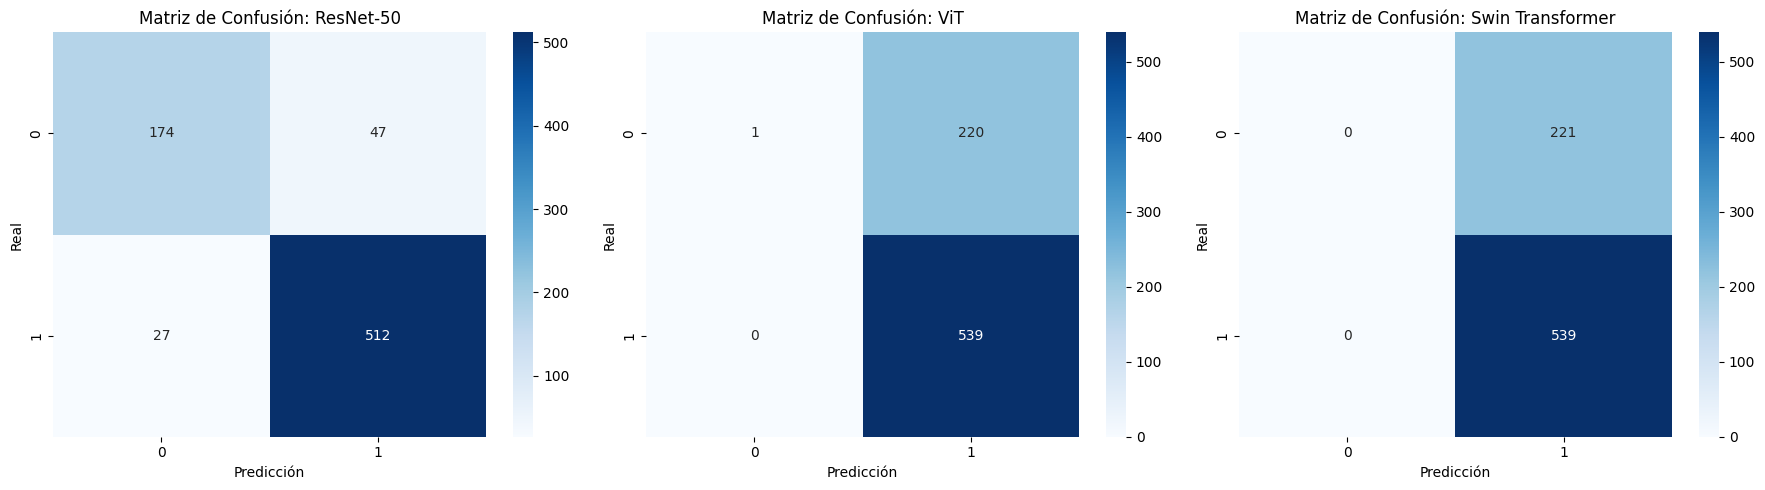

In [ ]:

# @title 5.2. Evaluación de cada modelo
print("Evaluando ResNet-50...")
acc_resnet, f1_resnet, prec_resnet, rec_resnet, cm_resnet = evaluate_model(model_resnet, test_loader)

print("Evaluando Vision Transformer...")
acc_vit, f1_vit, prec_vit, rec_vit, cm_vit = evaluate_model(model_vit, test_loader)

print("Evaluando Swin Transformer...")
acc_swin, f1_swin, prec_swin, rec_swin, cm_swin = evaluate_model(model_swin, test_loader)

# Crear un DataFrame para la comparación
data = {
    'Modelo': ['ResNet-50', 'ViT', 'Swin Transformer'],
    'Precisión': [acc_resnet, acc_vit, acc_swin],
    'F1-Score': [f1_resnet, f1_vit, f1_swin],
    'Recall': [rec_resnet, rec_vit, rec_swin],
    'Precision': [prec_resnet, prec_vit, prec_swin]
}

metrics_df = pd.DataFrame(data).set_index('Modelo')
print("\n--- Tabla de Métricas de Rendimiento ---")
print(metrics_df)

# Visualizar las matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión: ResNet-50')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz de Confusión: ViT')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

sns.heatmap(cm_swin, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Matriz de Confusión: Swin Transformer')
axes[2].set_xlabel('Predicción')
axes[2].set_ylabel('Real')

plt.tight_layout()
plt.show()


* ResNet-50: balancea muy bien Precision y Recall → el mejor desempeño general.

* ViT y Swin: tienen Recall = 1.0 (no se les escapa ningún positivo), pero su Precision es baja (~0.71), lo que significa que predicen demasiados falsos positivos.


-----

## 6\. Análisis Comparativo y Conclusión

### 6.1. Comparación de Costo Computacional


In [ ]:

# @title 6.1.1. Información de los modelos
# Obtener el número de parámetros
params_resnet = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)
params_vit = sum(p.numel() for p in model_vit.parameters() if p.requires_grad)
params_swin = sum(p.numel() for p in model_swin.parameters() if p.requires_grad)

data_cost = {
    'Modelo': ['ResNet-50', 'ViT', 'Swin Transformer'],
    'Tiempo de Entrenamiento (s)': [time_resnet, time_vit, time_swin],
    'Parámetros Entrenables': [f'{params_resnet:,}', f'{params_vit:,}', f'{params_swin:,}']
}

cost_df = pd.DataFrame(data_cost).set_index('Modelo')
print("\n--- Tabla de Costo Computacional ---")
print(cost_df)



--- Tabla de Costo Computacional ---
                  Tiempo de Entrenamiento (s) Parámetros Entrenables
Modelo                                                              
ResNet-50                          313.151739             23,512,130
ViT                                730.595803             85,800,194
Swin Transformer                   785.993799             86,743,240


### 6.2. Facilidad de Convergencia

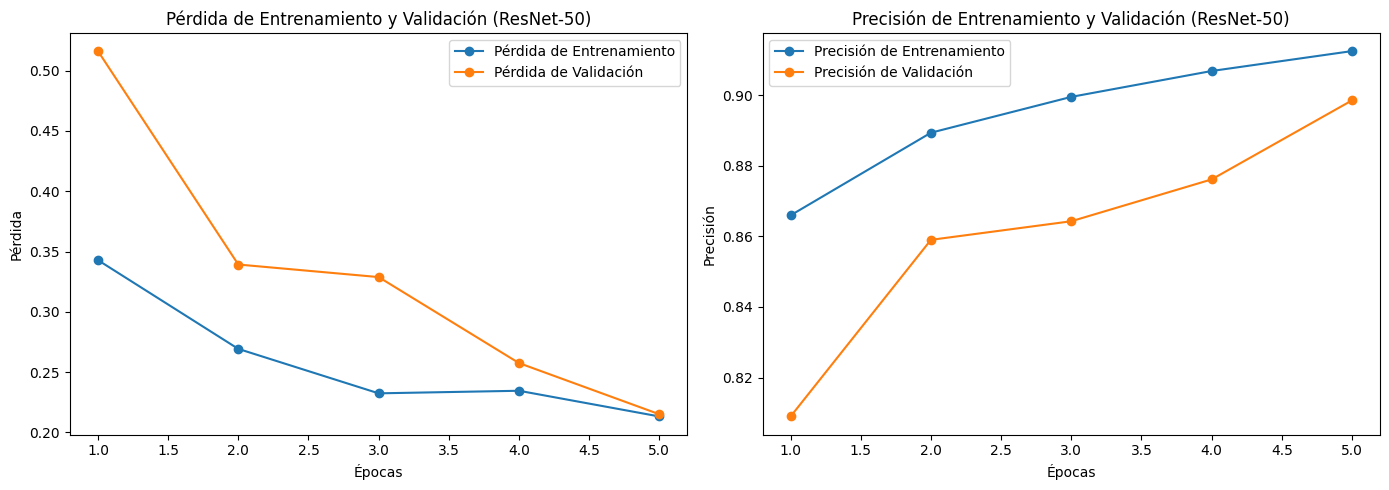

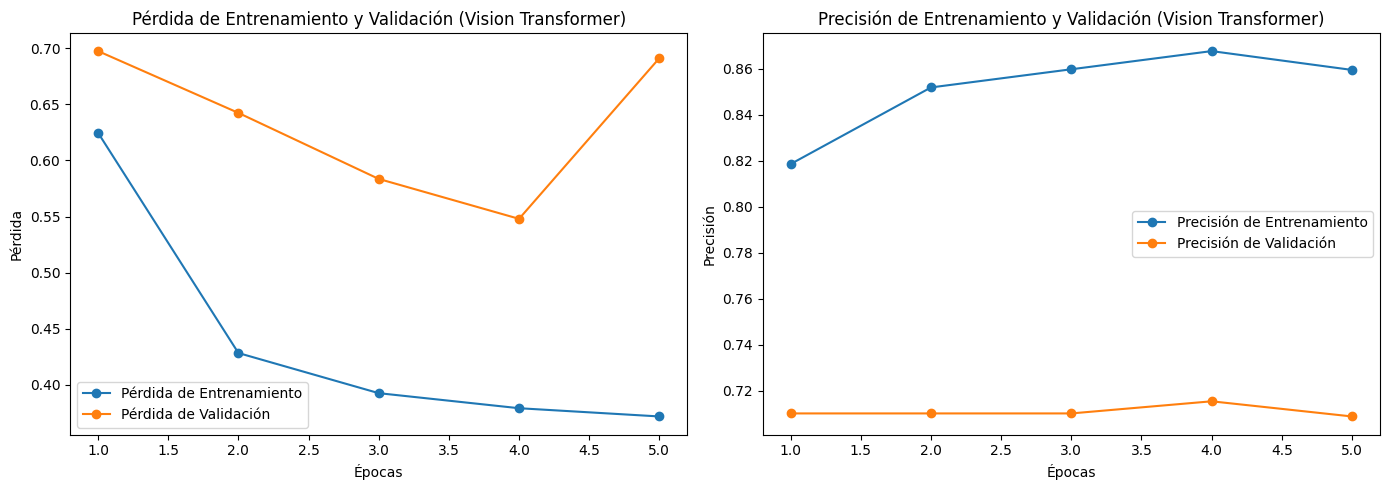

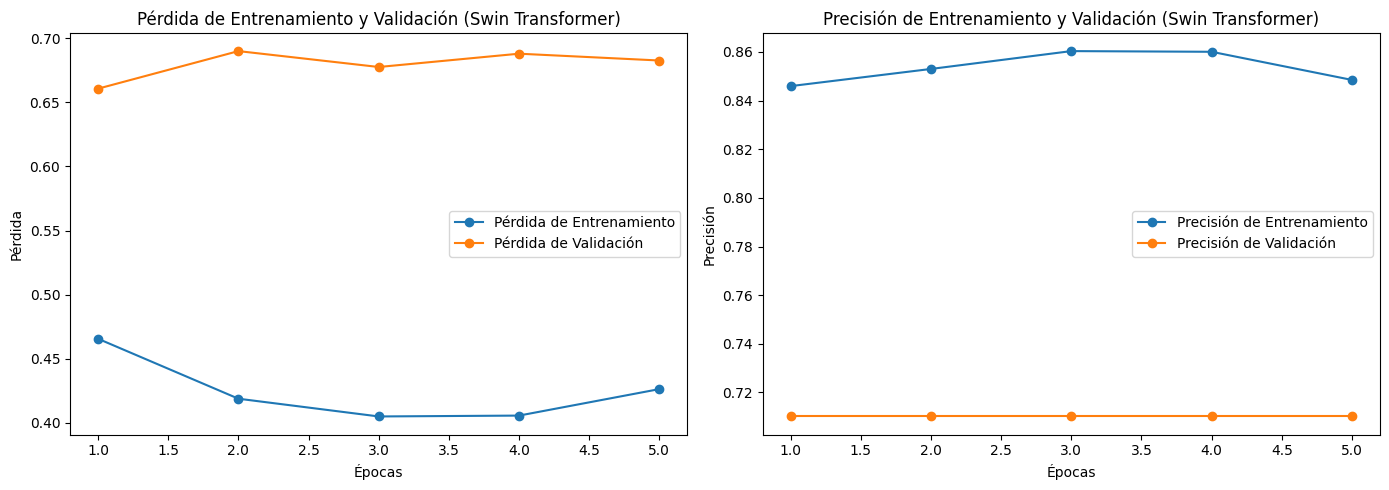

In [ ]:

# @title 6.2.1. Gráficos de Pérdida y Precisión
def plot_metrics(train_losses, val_losses, train_acc, val_acc, title):
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Pérdida
    ax1.plot(epochs, train_losses, 'o-', label='Pérdida de Entrenamiento')
    ax1.plot(epochs, val_losses, 'o-', label='Pérdida de Validación')
    ax1.set_title(f'Pérdida de Entrenamiento y Validación ({title})')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.legend()

    # Precisión
    ax2.plot(epochs, train_acc, 'o-', label='Precisión de Entrenamiento')
    ax2.plot(epochs, val_acc, 'o-', label='Precisión de Validación')
    ax2.set_title(f'Precisión de Entrenamiento y Validación ({title})')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Precisión')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses_resnet, val_losses_resnet, train_acc_resnet, val_acc_resnet, 'ResNet-50')
plot_metrics(train_losses_vit, val_losses_vit, train_acc_vit, val_acc_vit, 'Vision Transformer')
plot_metrics(train_losses_swin, val_losses_swin, train_acc_swin, val_acc_swin, 'Swin Transformer')